In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('Datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
# -------- import part ----------
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras import layers,models

In [4]:
# --------- fix random seed -----------

def set_seed(seed_value=5240):
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

In [5]:
TRAIN_DATADIR = 'Datasets'
CATEGORIES = ["female", "male"]   # Class 0=female, Class 1=male
IMG_SIZE = 50

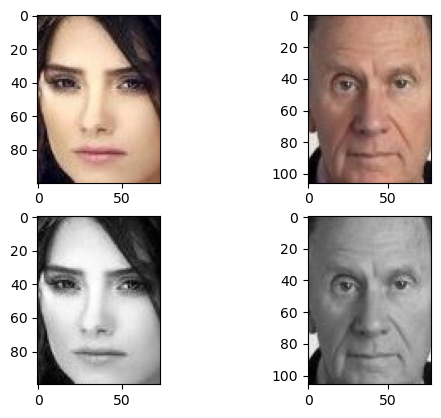

In [6]:
# ------ show examples of color and gray images -------

female_img_array = cv2.imread('Datasets/female/112944.jpg.jpg')
male_img_array = cv2.imread('Datasets/male/080654.jpg.jpg')

plt.subplot(2,2,1)
plt.imshow(female_img_array[:,:,::-1])
plt.subplot(2,2,2)
plt.imshow(male_img_array[:,:,::-1])
female_img_gray = cv2.imread('Datasets/female/112944.jpg.jpg',cv2.IMREAD_GRAYSCALE)
male_img_gray = cv2.imread('Datasets/male/080654.jpg.jpg',cv2.IMREAD_GRAYSCALE)
plt.subplot(2,2,3)
plt.imshow(female_img_gray,cmap='gray')
plt.subplot(2,2,4)
plt.imshow(male_img_gray,cmap='gray')
plt.show()

In [9]:
import os
import numpy as np
import shutil
import random



def split_to_train_test(path, ratio=0.10, seed=1024):
    files_name = os.listdir(path)
    np.random.seed(seed)
    np.random.shuffle(files_name)
    
    train, test = np.split(np.array(files_name), [int(len(files_name)* (1 - ratio))])
    
    return train, test, files_name

female = split_to_train_test('Datasets/female')

def get_files(path):
    data = split_to_train_test(path)
    
    train = [f'{path}/{name}' for name in data[0]]
    test = [f'{path}/{name}' for name in data[1]]
    
#     try:
#         for i in CATEGORIES:
#             os.makedirs(f'Datasets/split/train/{i}')
#             os.makedirs(f'Datasets/split/test/{i}')
        
                
#     except FileExistsError:
#         for name in train:
#             for i in CATEGORIES:
#                 shutil.copy(name, f'Datasets/split/train/{i}')

#         for name in test:
#             for i in lab:
#                 shutil.copy(name, f'Datasets/split/test/{i}')
    
    return train, test, data[2]
    

female, male = get_files('Datasets/female'), get_files('Datasets/male')


In [10]:
# number of training and testing samples
female_train = len(female[0])
male_train = len(male[0])
female_test = len(female[1])
male_test = len(male[1])
train_total = female_train + male_train
test_total = female_test + male_test
print("There are",train_total,"training samples,","including",female_train,"female samples, and",male_train,"male samples.")
print("There are",test_total,"testing samples,","including",female_test,"female samples, and",male_test,"male samples.")

There are 10483 training samples, including 5256 female samples, and 5227 male samples.
There are 1166 testing samples, including 585 female samples, and 581 male samples.


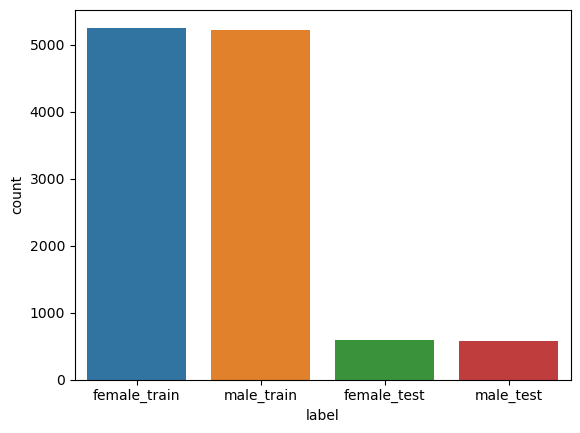

In [11]:
# distribution of gender labels
x = ['female_train','male_train','female_test','male_test']
y = [female_train,male_train,female_test,male_test]
df = pd.DataFrame({"label":x,"count":y})
sns.barplot(x="label",y="count",data=df)
pass

In [12]:
def load_img_arrays(data_dir):
    img_arrays = []
    for category in CATEGORIES:  
        path = os.path.join(data_dir,category)  
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=female 1=male
        
        for img in os.listdir(path): 
            try:
                # convert to array
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                # resize to normalize data size
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                img_arrays.append([new_array, class_num]) 
            except Exception as e:  # keep the output clean
                pass
    return img_arrays

def create_X_and_y(data):
    random.shuffle(data) # shuffle the data
    X = []
    y = []
    for features,label in data: # X for features, y for labels
        X.append(features)
        y.append(label)
    X = np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE,1) # reshape X
    return X, y

def convert_and_normalize(train_images, test_images, train_labels, test_labels):
    # convert list to ndarray, and reshape the labels
    test_y = np.array(test_labels).reshape(len(test_labels),1)
    train_y = np.array(train_labels).reshape(len(train_labels),1)

    # Normalize pixel values to be between 0 and 1
    train_X, test_X = train_images / 255.0, test_images / 255.0
    return train_X, test_X, train_y, test_y

In [13]:
# run the program
set_seed()
training_images, testing_images = load_img_arrays('Datasets/split/train/'),load_img_arrays('Datasets/split/test')
X_train, y_train = create_X_and_y(training_images)
X_test, y_test = create_X_and_y(testing_images)
train_X, test_X, train_y, test_y = convert_and_normalize(X_train, X_test, y_train, y_test)

# check the shape of data
print(f"train_images - Type: {type(train_X)}, Shape {train_X.shape}")
print(f"test_images - Type: {type(test_X)}, Shape {test_X.shape}")
print(f"train_labels - Type: {type(train_y)}, Shape {train_y.shape}")
print(f"test_labels - Type: {type(test_y)}, Shape {test_y.shape}")

train_images - Type: <class 'numpy.ndarray'>, Shape (20966, 50, 50, 1)
test_images - Type: <class 'numpy.ndarray'>, Shape (0, 50, 50, 1)
train_labels - Type: <class 'numpy.ndarray'>, Shape (20966, 1)
test_labels - Type: <class 'numpy.ndarray'>, Shape (0, 1)


In [19]:
# setting 1: original model

CNNmodel = keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(50, 50, 1), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'), 
    layers.Dense(128, activation = 'relu'),
    layers.Dense(2, activation = 'sigmoid')
])

CNNmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = CNNmodel.fit(train_X, train_y, epochs = 1, validation_split=0.2, batch_size=128, verbose=1, callbacks=[callback])



132/132 [==============================] - 35s 250ms/step - loss: 0.6944 - accuracy: 0.4954 - val_loss: 0.6935 - val_accuracy: 0.5005


In [ ]:
# setting 8: dropout
CNNmodel8 = keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(50, 50, 1), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(2, activation = 'sigmoid')
])

CNNmodel8.compile(optimizer='adam',
              #loss="binary_crossentropy",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = CNNmodel8.fit(train_X, train_y, epochs = 20, validation_split=0.2, batch_size=32, verbose=1, callbacks=[callback])

evaluate(CNNmodel8,test_X,test_y)

In [25]:
history.history

{'loss': [0.6943740248680115],
 'accuracy': [0.4954090118408203],
 'val_loss': [0.6934547424316406],
 'val_accuracy': [0.5004768967628479]}

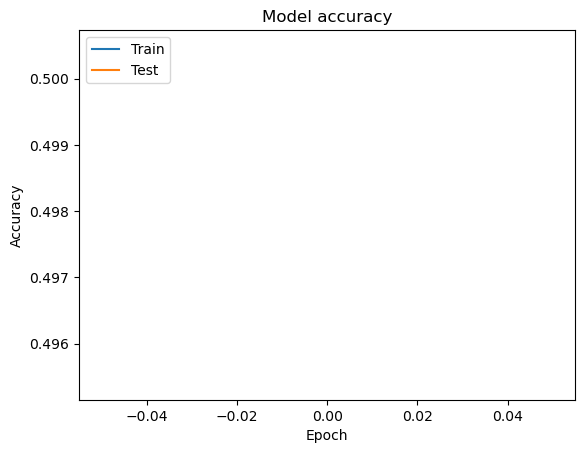

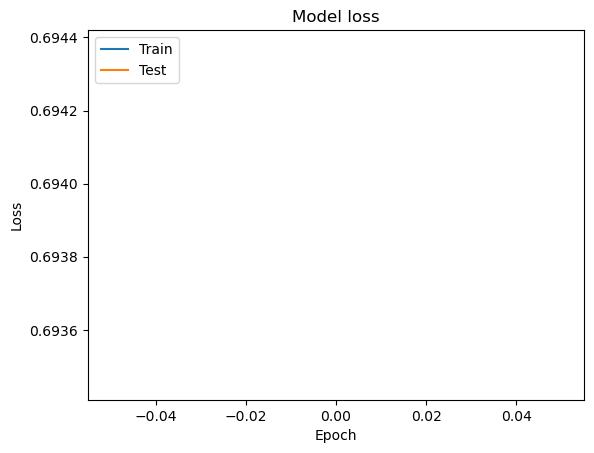

In [26]:
# 绘制训练 & 验证的准确率值
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()